In [1]:
from comet_ml import API
import comet_ml
import io
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import time
sns.set(context='paper', style="whitegrid", font_scale=2)
colors = ["g", "b", "r", "y", "m",  "c", "tab:brown", ""]
colors = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#42d4f4', 
    'grey', '#469990', 'black', '#9A6324', '#fffac8', '#800000', 
    '#aaffc3', '#000075', '#a9a9a9', '#000000'
]
%matplotlib inline
linewidth = 3

comet_api = API()
comet_api.get()

['schattengenie', 'shir994']

In [2]:
def get_parameter_by_key(exp, key):
    parameters = exp.get_parameters_summary()
    for parameter in parameters:
        if parameter['name'] == key:
            return parameter['valueCurrent']
    return None

def new_to_old_metric(exp, key):
    metric = exp.get_metrics(key)
    vals = [float(m['metricValue']) for m in metric]
    return vals

def stack_lists(data, n=1000):
    new_data = []
    for d in data:
        if len(d) > n:
            new_data.append(d[:n])
        elif len(d) < n:
            new_data.append(
                np.concatenate([d, d[-1].repeat(n - len(d))])
            )
    return np.vstack(new_data).T

def preprocess_gp(vals):
    return np.minimum.accumulate(vals)

def add_zero_point(vals, point):
    return np.array([point] + vals.tolist())

In [3]:
num_epochs = 1500

experiments = comet_api.get(workspace='schattengenie', project_name='em-showers-network-training')
experiments_balanced = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '5'
]
experiments_emulsion = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '0'
]
experiments_edge = [
    exp for exp in experiments
    if get_parameter_by_key(exp, "num_layers_edge_conv") == '8'
]

In [4]:
balanced_roc_auc = []
for exp in experiments_balanced:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    balanced_roc_auc.append(roc_auc_test)
balanced_roc_auc = stack_lists(balanced_roc_auc, num_epochs)


edge_roc_auc = []
for exp in experiments_edge:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    edge_roc_auc.append(roc_auc_test)
edge_roc_auc = stack_lists(edge_roc_auc, num_epochs)

emulsion_roc_auc = []
for exp in experiments_emulsion:
    roc_auc_test = np.array(new_to_old_metric(exp, 'roc_auc_test'))
    emulsion_roc_auc.append(roc_auc_test)
emulsion_roc_auc = stack_lists(emulsion_roc_auc, num_epochs)

In [5]:
def plot_roc_auc_test(data, label="", i=0):
    idx = np.arange(len(data))
    mean = data.mean(1)
    std = data.std(1) / np.sqrt(data.shape[1])
    upper = mean + std
    lower = mean - std
    plt.plot(idx, mean, c=colors[i], linewidth=linewidth, label=label, zorder=5)
    plt.plot(idx, upper, 'b--', c=colors[i], zorder=5)
    plt.plot(idx, lower, 'b--', c=colors[i], zorder=5)
    plt.fill_between(idx, lower, upper, alpha=0.2, color=colors[i], zorder=5)

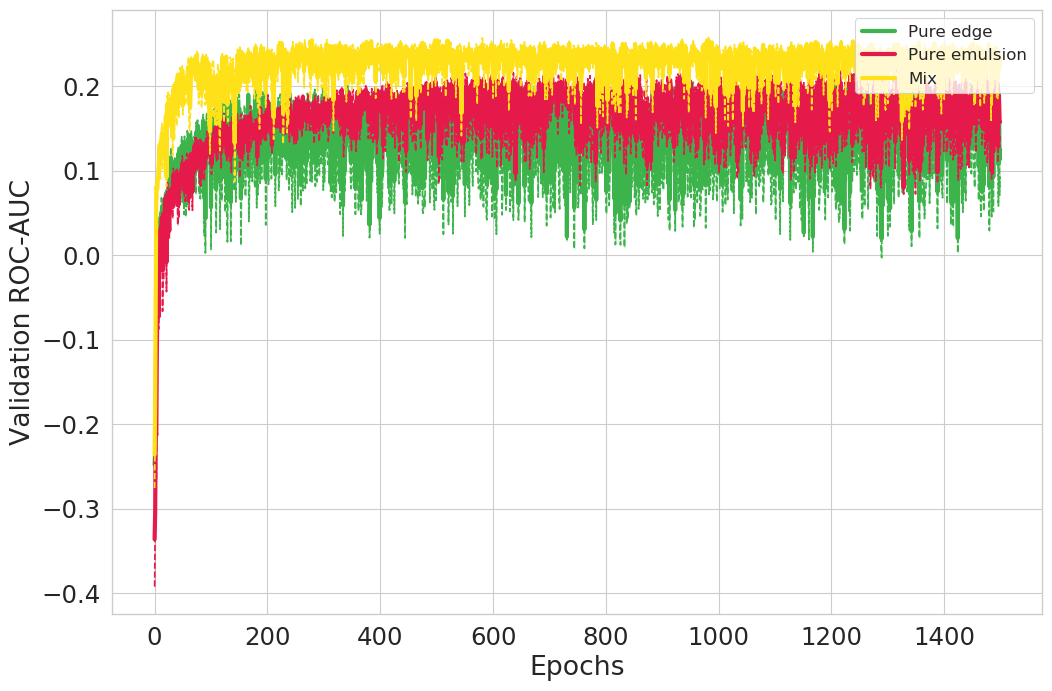

In [6]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title("")
plot_roc_auc_test(edge_roc_auc, i=1, label="Pure edge")
plot_roc_auc_test(emulsion_roc_auc, i=0, label="Pure emulsion")
plot_roc_auc_test(balanced_roc_auc, i=2, label="Mix")

plt.ylabel("Validation ROC-AUC")
plt.xlabel("Epochs")
# plt.ylim
plt.legend(loc='upper right', fontsize='large')
plt.savefig("validation_roc_auc.pdf", bbox_inches='tight')
plt.show()